# DQN Optimized Trajectory: Visualization Suite

This notebook trains an agent (SB3 DQN with ZF + proportional during training) and visualizes:
- Optimized UAV trajectory (greedy run)
- Convergence curve (episode returns)
- 10 optimized UAV episodes with dwell-time markers


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add src to path
sys.path.append('..')

from src.training.configs import TrainingConfig
from src.training.trainer import Trainer




In [2]:
# 1) Train DQN with optimized transmit (ZF + proportional)
cfg = TrainingConfig(
    agent_type='dqn',
    total_timesteps=50000,
    learning_rate=1e-3,
    gamma=0.99,
    batch_size=64,
    beamforming_method='zf',
    power_optimization_strategy='proportional',
    verbose=1,
)
trainer = Trainer(cfg)
env = trainer.setup_environment()
trainer.setup_agent()
stats = trainer.train()



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting training with dqn agent...
Training completed in 69.20 seconds


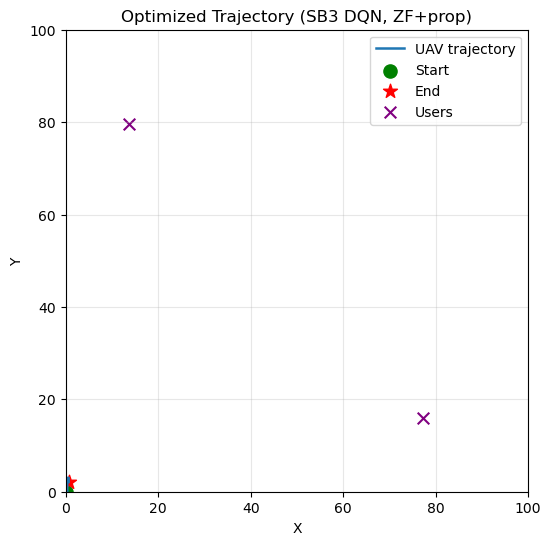

In [3]:
# 2) Plot optimized trajectory (greedy run)
# Switch to test transmit strategy if needed (here we keep ZF+prop for optimized-signal trajectory)
base_env = env.env if hasattr(env, 'env') else env

obs, _ = env.reset()
done = False
while not done:
    action, _ = trainer.agent.predict(obs, deterministic=True)
    action = int(np.asarray(action).ravel()[0])  # 强制转为 int
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

traj = base_env.get_trajectory()
users = base_env.get_user_positions()

plt.figure(figsize=(6,6))
plt.plot(traj[:,0], traj[:,1], '-', lw=1.8, label='UAV trajectory')
plt.scatter(traj[0,0], traj[0,1], c='green', s=90, label='Start')
plt.scatter(traj[-1,0], traj[-1,1], c='red', s=110, marker='*', label='End')
plt.scatter(users[:,0], users[:,1], c='purple', s=70, marker='x', label='Users')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, base_env.env_size[0]); plt.ylim(0, base_env.env_size[1])
plt.xlabel('X'); plt.ylabel('Y')
plt.title('Optimized Trajectory (SB3 DQN, ZF+prop)')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()



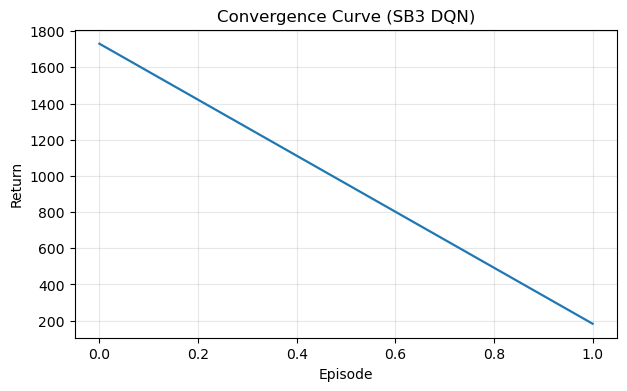

In [4]:
# 3) Convergence curve (episode returns captured by training callback)
rewards = trainer.callback.episode_rewards if trainer.callback else []
plt.figure(figsize=(7,4))
plt.plot(rewards, lw=1.6)
plt.xlabel('Episode'); plt.ylabel('Return')
plt.title('Convergence Curve (SB3 DQN)')
plt.grid(True, alpha=0.3)
plt.show()



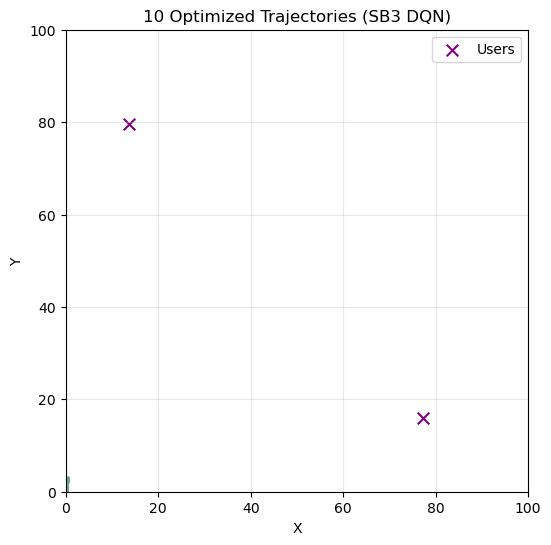

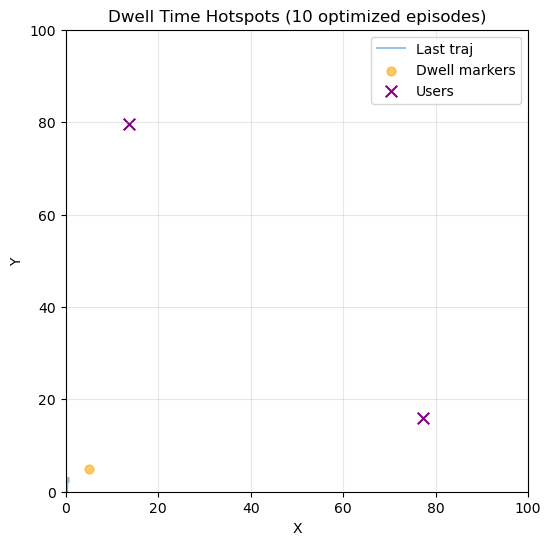

In [5]:
# 4) 10 optimized trajectories with dwell-time markers
# Helper: accumulate dwell time over a coarse grid

def compute_dwell_map(traj, grid_size=(10,10), env_size=(100,100)):
    gx, gy = grid_size
    w, h = env_size[:2]
    dwell = np.zeros((gx, gy), dtype=float)
    # Map each point to a grid cell
    for i in range(1, len(traj)):
        x, y = traj[i,0], traj[i,1]
        ix = min(gx-1, max(0, int(x / (w / gx))))
        iy = min(gy-1, max(0, int(y / (h / gy))))
        dwell[ix, iy] += 1  # step count as proxy for dwell time
    return dwell

# Collect trajectories and dwell maps
num_episodes = 10
trajectories = []
dwell_maps = []

for ep in range(num_episodes):
    obs, _ = env.reset()
    done = False
    while not done:
        action, _ = trainer.agent.predict(obs, deterministic=True)
        action = int(np.asarray(action).ravel()[0])  # 强制转为标量 int
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    traj = base_env.get_trajectory()
    trajectories.append(traj)
    dwell_maps.append(compute_dwell_map(traj, grid_size=(10,10), env_size=base_env.env_size))

# Plot all trajectories
plt.figure(figsize=(6,6))
for traj in trajectories:
    plt.plot(traj[:,0], traj[:,1], '-', alpha=0.6)
plt.scatter(users[:,0], users[:,1], c='purple', s=70, marker='x', label='Users')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, base_env.env_size[0]); plt.ylim(0, base_env.env_size[1])
plt.xlabel('X'); plt.ylabel('Y')
plt.title('10 Optimized Trajectories (SB3 DQN)')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# Aggregate dwell map and show markers scaled by dwell time
agg = np.sum(np.stack(dwell_maps, axis=0), axis=0)
# Convert grid cells to coordinates and sizes
xs, ys, sizes = [], [], []
gx, gy = agg.shape
for ix in range(gx):
    for iy in range(gy):
        val = agg[ix, iy]
        if val <= 0:
            continue
        # center of the cell
        cx = (ix + 0.5) * (base_env.env_size[0] / gx)
        cy = (iy + 0.5) * (base_env.env_size[1] / gy)
        xs.append(cx); ys.append(cy); sizes.append(val)

sizes = np.array(sizes)
if sizes.size > 0:
    sizes = 40 + 3.0 * (sizes - sizes.min()) / (np.ptp(sizes) + 1e-9) * 160  # scale

plt.figure(figsize=(6,6))
plt.plot(trajectories[-1][:,0], trajectories[-1][:,1], '-', lw=1.3, alpha=0.5, label='Last traj')
plt.scatter(xs, ys, s=sizes, c='orange', alpha=0.6, label='Dwell markers')
plt.scatter(users[:,0], users[:,1], c='purple', s=70, marker='x', label='Users')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, base_env.env_size[0]); plt.ylim(0, base_env.env_size[1])
plt.xlabel('X'); plt.ylabel('Y')
plt.title('Dwell Time Hotspots (10 optimized episodes)')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()



=== 诊断收敛曲线问题 ===
Episode rewards 数量: 2
前5个奖励值: [1730.723334, 183.007317]
奖励值数据类型: <class 'float'>
奖励值范围: (183.007317, 1730.723334)
包含 NaN: False
包含 inf: False


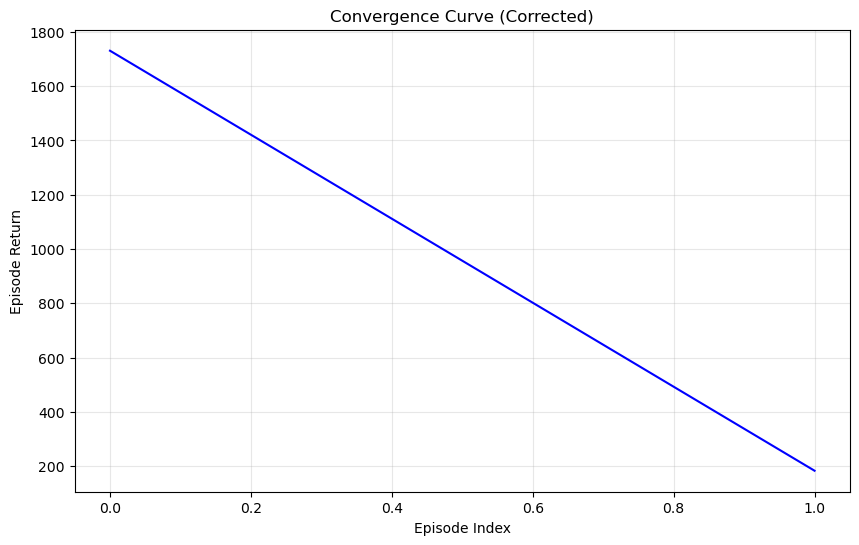

In [7]:
import sys
sys.path.append('src')
import numpy as np
import matplotlib.pyplot as plt

# 快速诊断收敛曲线问题
print("=== 诊断收敛曲线问题 ===")

# 假设你已经训练了 trainer
# 请在 notebook 中运行这段代码来诊断

# 检查 callback 状态
def debug_callback(trainer):
    if trainer.callback is None:
        print("ERROR: trainer.callback is None")
        return
    
    rewards = trainer.callback.episode_rewards
    print(f"Episode rewards 数量: {len(rewards)}")
    print(f"前5个奖励值: {rewards[:5] if len(rewards) > 0 else 'None'}")
    print(f"奖励值数据类型: {type(rewards[0]) if len(rewards) > 0 else 'N/A'}")
    print(f"奖励值范围: {(min(rewards), max(rewards)) if len(rewards) > 0 else 'N/A'}")
    
    # 检查是否有 NaN 或 inf
    if len(rewards) > 0:
        rewards_array = np.array(rewards)
        print(f"包含 NaN: {np.any(np.isnan(rewards_array))}")
        print(f"包含 inf: {np.any(np.isinf(rewards_array))}")
        
        # 正确的绘图方式
        plt.figure(figsize=(10, 6))
        episode_indices = range(len(rewards))  # 使用索引作为 x 轴
        plt.plot(episode_indices, rewards, 'b-', linewidth=1.5)
        plt.xlabel('Episode Index')
        plt.ylabel('Episode Return') 
        plt.title('Convergence Curve (Corrected)')
        plt.grid(True, alpha=0.3)
        plt.show()

# 在你的 notebook 中调用：
debug_callback(trainer)
